In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import findspark
findspark.init()

import pyspark
from pyspark.sql import *
import pyspark.sql.functions as func
from pyspark.sql.types import *

# Language processing
import nltk

In [2]:
spark = SparkSession.builder.getOrCreate()

In [3]:
sc = spark.sparkContext

In [4]:
messages = spark.read.load('../sample_parquet/first_1000/')

In [5]:
messages.columns

['distinguished',
 'retrieved_on',
 'gilded',
 'edited',
 'id',
 'parent_id',
 'flair_text',
 'author',
 'score',
 'ups',
 'created_utc',
 'flair_css_class',
 'subreddit',
 'subreddit_id',
 'stickied',
 'link_id',
 'controversiality',
 'body']

In [6]:
idx2labels = dict(enumerate(messages.columns))
labels2idx = {k:v for (v, k) in idx2labels.items()}

In [7]:
messages_rdd = messages.rdd

In [8]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
en_stopwords = stopwords.words('english')
en_stemmer = SnowballStemmer('english')

### Messages processing (tokenize, stemmatize, stopwords, ...)
Should add lemmatize?

In [9]:
msg_bodies = messages_rdd.map(lambda d: (d[labels2idx['parent_id']], d['id'], d['body']))
cleaned_bodies = msg_bodies.filter(lambda d: d[2] != '[removed]' and d[2] != '[deleted]')
tokens = cleaned_bodies.map(lambda d: (d[0], d[1], nltk.tokenize.word_tokenize(d[2])))
short_bodies = tokens.map(lambda d: (d[0], d[1], [en_stemmer.stem(word) for word in d[2] if word not in en_stopwords]))
short_bodies.take(10)

[('t1_c595qio',
  'c595rma',
  ['the',
   'fear',
   "'s",
   '``',
   'grass',
   'alway',
   'greener',
   "''",
   'thing',
   'keep',
   '.',
   'i',
   've',
   'plenti',
   'type',
   'job',
   ',',
   'up',
   'down',
   ',',
   'none',
   'paid',
   'enough',
   'cover',
   'current',
   'mortgag',
   'student',
   'loan',
   'payment',
   '.']),
 ('t3_w0bkb', 'c595rqe', ['upvot', '!']),
 ('t1_c595gbw',
  'c595rwc',
  ['it', "'s", 'real', ',', "'s", 'new', 'york', 'citi', '.']),
 ('t1_c595iaf',
  'c595sdr',
  ['what',
   "'s",
   '...',
   'like',
   '22',
   'lbs',
   '?',
   'squat',
   'bar',
   '2x',
   'bw',
   '.',
   'more',
   'fittit',
   '.']),
 ('t3_w0aia', 'c595sop', ['ever', 'end', '?']),
 ('t1_c594mv6',
  'c595sui',
  ['your', 'user', 'name', 'made', 'long', 'long', 'day', 'worth', '.']),
 ('t1_c595s8b',
  'c595t5u',
  ['nope',
   ':',
   'd',
   'sc2s',
   'help',
   'lot',
   ':',
   'd',
   'http',
   ':',
   '//starcraft2strategy.com/']),
 ('t1_c58vdyu', 'c595

### Simple positive/negative/neutral scores based on NLTK sentiment intensity analyzer

In [10]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [11]:
sid = SentimentIntensityAnalyzer()
sent_bodies = cleaned_bodies.map(lambda d: (d[0], d[1], d[2], sid.polarity_scores(d[2])))
sent_bodies.take(10)

[('t1_c595qio',
  'c595rma',
  'The fear that it\'s a "grass is always greener" thing is what keeps me with it. I\'ve had plenty of other types of jobs before, and they all had their ups and downs, and none of them paid enough to cover my current mortgage and student loan payments.',
  {'neg': 0.065, 'neu': 0.935, 'pos': 0.0, 'compound': -0.4939}),
 ('t3_w0bkb',
  'c595rqe',
  'Upvote!',
  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('t1_c595gbw',
  'c595rwc',
  "It's real, it's in New York City.",
  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('t1_c595iaf',
  'c595sdr',
  "What's he now... like 22 lbs?  Squat the bar is a 2x BW.  More than most of fittit can do.",
  {'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'compound': 0.3612}),
 ('t3_w0aia',
  'c595sop',
  'does it ever end?\n',
  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}),
 ('t1_c594mv6',
  'c595sui',
  'Your user name just made my long long day worth it. ',
  {'neg': 0.0, 'neu': 0.84, 'pos': 0.1

### TODO:
- Spacy
- TextBlob
- Hatespeech
- Vulgarity
- Lack of empathy? How ?
- Create a general classifier pipeline to measure those quantities

### TextBlob

In [12]:
from textblob import TextBlob

#### Blob polarity and subjectivity

In [13]:
blobs_sent = cleaned_bodies.map(lambda d: (d[0], d[1], d[2], TextBlob(d[2]).sentiment))
blobs_sent.take(10)

[('t1_c595qio',
  'c595rma',
  'The fear that it\'s a "grass is always greener" thing is what keeps me with it. I\'ve had plenty of other types of jobs before, and they all had their ups and downs, and none of them paid enough to cover my current mortgage and student loan payments.',
  Sentiment(polarity=-0.041666666666666664, subjectivity=0.425)),
 ('t3_w0bkb', 'c595rqe', 'Upvote!', Sentiment(polarity=0.0, subjectivity=0.0)),
 ('t1_c595gbw',
  'c595rwc',
  "It's real, it's in New York City.",
  Sentiment(polarity=0.20454545454545453, subjectivity=0.6818181818181818)),
 ('t1_c595iaf',
  'c595sdr',
  "What's he now... like 22 lbs?  Squat the bar is a 2x BW.  More than most of fittit can do.",
  Sentiment(polarity=0.5, subjectivity=0.5)),
 ('t3_w0aia',
  'c595sop',
  'does it ever end?\n',
  Sentiment(polarity=0.0, subjectivity=0.0)),
 ('t1_c594mv6',
  'c595sui',
  'Your user name just made my long long day worth it. ',
  Sentiment(polarity=0.06666666666666667, subjectivity=0.3)),
 ('t1_

#### Blob polarity, subjectivity and word assessement

In [14]:
blobs_words_sent = cleaned_bodies.map(lambda d: (d[0], d[1], d[2], TextBlob(d[2]).sentiment_assessments))
blobs_words_sent.take(10)

[('t1_c595qio',
  'c595rma',
  'The fear that it\'s a "grass is always greener" thing is what keeps me with it. I\'ve had plenty of other types of jobs before, and they all had their ups and downs, and none of them paid enough to cover my current mortgage and student loan payments.',
  Sentiment(polarity=-0.041666666666666664, subjectivity=0.425, assessments=[(['other'], -0.125, 0.375, None), (['enough'], 0.0, 0.5, None), (['current'], 0.0, 0.4, None)])),
 ('t3_w0bkb',
  'c595rqe',
  'Upvote!',
  Sentiment(polarity=0.0, subjectivity=0.0, assessments=[])),
 ('t1_c595gbw',
  'c595rwc',
  "It's real, it's in New York City.",
  Sentiment(polarity=0.20454545454545453, subjectivity=0.6818181818181818, assessments=[(['real', 'new'], 0.20454545454545453, 0.6818181818181818, None)])),
 ('t1_c595iaf',
  'c595sdr',
  "What's he now... like 22 lbs?  Squat the bar is a 2x BW.  More than most of fittit can do.",
  Sentiment(polarity=0.5, subjectivity=0.5, assessments=[(['more'], 0.5, 0.5, None), (['

#### Blob with NaiveBayesAnalyzer

In [15]:
from textblob.sentiments import NaiveBayesAnalyzer

In [16]:
blobs_bayes = cleaned_bodies.map(lambda d: (d[0], d[1], d[2], TextBlob(d[2], analyzer=NaiveBayesAnalyzer()).sentiment))
blobs_bayes.take(10)

[('t1_c595qio',
  'c595rma',
  'The fear that it\'s a "grass is always greener" thing is what keeps me with it. I\'ve had plenty of other types of jobs before, and they all had their ups and downs, and none of them paid enough to cover my current mortgage and student loan payments.',
  Sentiment(classification='pos', p_pos=0.9846928555799577, p_neg=0.015307144420042452)),
 ('t3_w0bkb',
  'c595rqe',
  'Upvote!',
  Sentiment(classification='pos', p_pos=0.5, p_neg=0.5)),
 ('t1_c595gbw',
  'c595rwc',
  "It's real, it's in New York City.",
  Sentiment(classification='pos', p_pos=0.6036820993122206, p_neg=0.3963179006877791)),
 ('t1_c595iaf',
  'c595sdr',
  "What's he now... like 22 lbs?  Squat the bar is a 2x BW.  More than most of fittit can do.",
  Sentiment(classification='pos', p_pos=0.7244629685965851, p_neg=0.2755370314034154)),
 ('t3_w0aia',
  'c595sop',
  'does it ever end?\n',
  Sentiment(classification='pos', p_pos=0.573611675338729, p_neg=0.42638832466127125)),
 ('t1_c594mv6',
  

### Spacy: Train a neural net using OpinionLexicon (see text classifier example spacy)

In [17]:
# TODO

### Vulgarity

In [18]:
bad_words = spark.read.csv('../bad_words_lexicon/en.csv', header=True)
bad_words_rdd = bad_words.rdd.map(lambda d: d[0])

In [19]:
bad_words_set = set(bad_words_rdd.collect())

In [20]:
vulgarity = tokens.map(lambda d: (d[0], d[1], d[2], len(set(d[2]).intersection(bad_words_set))))
vulgarity_count = vulgarity.map(lambda d: d[3])
vul_count = vulgarity_count.collect()

In [21]:
vulgarity.filter(lambda d: d[3] > 0).take(10)

[('t1_c5930e9',
  'c5961i5',
  ['Ohh',
   'a',
   'stroller',
   'OK',
   '...',
   '.cultural',
   'differences',
   'are',
   'a',
   'bitch',
   ',',
   'yet',
   'they',
   'are',
   'the',
   'spice',
   'of',
   'life'],
  1),
 ('t3_vzr27',
  'c5965fh',
  ['that',
   'fucking',
   'lighting',
   'engine',
   'makes',
   'my',
   'man',
   'juices',
   'ooze'],
  1),
 ('t1_c594z98',
  'c596d7h',
  ['shit',
   'compared',
   'to',
   'other',
   'ring-out/knock-back',
   'abilities',
   ',',
   'or',
   'just',
   'compared',
   'to',
   'sin',
   'jump',
   '?',
   'you',
   'do',
   "n't",
   'use',
   'it',
   'for',
   'the',
   'jump',
   'a',
   'large',
   'percentage',
   'of',
   'the',
   'time',
   'if',
   'you',
   "'re",
   'good',
   '(',
   'read',
   'as',
   ':',
   'Jeff',
   ')',
   '.'],
  1),
 ('t1_c594bex',
  'c596fjc',
  ['People',
   'like',
   'blaming',
   'others',
   'for',
   'things',
   'they',
   'can',
   'not',
   'necessarily',
   'control',
   '

In [22]:
vulgarity_pd = pd.DataFrame(vul_count, columns=['vulgarity'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb8f275358>]],
      dtype=object)

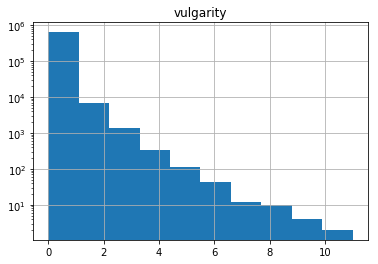

In [23]:
vulgarity_pd.hist(log=True)

In [24]:
msg_with_bw = vulgarity_pd[vulgarity_pd['vulgarity'] > 0]
# Fraction of messages with badwords
msg_with_bw.count() / vulgarity_pd.count()

vulgarity    0.088976
dtype: float64

### Hate speech

In [25]:
hate_speech = spark.read.csv('../hatespeech_lexicon/hatebase_dict.csv', header=True, sep=',')
hate_speech_rdd = hate_speech.rdd.map(lambda d: d[0][1:-2])
refined_hate = spark.read.csv('../hatespeech_lexicon/refined_ngram_dict.csv', header=True)
refined_hate_rdd = refined_hate.rdd.map(lambda d: d[0])

In [26]:
hate_speech_set = set(hate_speech_rdd.collect())
refined_hate_set = set(refined_hate_rdd.collect())

In [27]:
hate = tokens.map(lambda d: (d[0], d[1], d[2], len(set(d[2]).intersection(hate_speech_set))))
hate_count = hate.map(lambda d: d[3])
h_count = hate_count.collect()

In [28]:
hate.filter(lambda d: d[3] > 0).take(10)

[('t1_c5957sm',
  'c595ule',
  ['If',
   'you',
   'are',
   'denying',
   'the',
   'fact',
   'that',
   'mentally',
   'retarded',
   'people',
   'are',
   'never',
   'funny',
   'you',
   "'re",
   'denying',
   'them',
   'the',
   'right',
   'to',
   'be',
   'a',
   'human',
   'being'],
  1),
 ('t1_c5930e9',
  'c5961i5',
  ['Ohh',
   'a',
   'stroller',
   'OK',
   '...',
   '.cultural',
   'differences',
   'are',
   'a',
   'bitch',
   ',',
   'yet',
   'they',
   'are',
   'the',
   'spice',
   'of',
   'life'],
  1),
 ('t1_c595a9k',
  'c596ito',
  ['Many',
   'primate',
   'species',
   'have',
   'specific',
   'calls',
   'to',
   'alert',
   'each',
   'other',
   'to',
   'the',
   'presence',
   'of',
   'predatory',
   'birds',
   ';',
   'they',
   "'re",
   'a',
   'serious',
   'threat',
   '.',
   '[',
   'Plus',
   ',',
   'there',
   'seems',
   'to',
   'be',
   'plenty',
   'of',
   'evidence',
   'that',
   'early',
   'man',
   'was',
   'hunted',
   'by'

In [29]:
hate_pd = pd.DataFrame(h_count, columns=['hate'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcb8d437898>]],
      dtype=object)

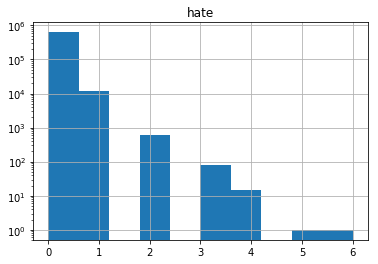

In [30]:
hate_pd.hist(log=True)

In [31]:
msg_with_hate = hate_pd[hate_pd['hate'] > 0]
# Fraction of messages with badwords
msg_with_hate.count() / hate_pd.count()

hate    0.019475
dtype: float64

In [32]:
test = refined_hate.rdd
test = test.map(lambda d: (d[0], d[1]))
test.sortBy(lambda d: d[1], ascending=False).take(10)

[('hate faggots', '0.912'),
 ('faggots like you', '0.905'),
 ('faggots like', '0.901'),
 ('this nigger', '0.889'),
 ('allah akbar', '0.87'),
 ('your a dirty', '0.87'),
 ('full of white trash', '0.867'),
 ('all niggers', '0.859'),
 ('you nigger', '0.827'),
 ('fucking nigger', '0.8')]

### Problems:
1. N-grams. Augmenting the reddits messages can be done easily, but computation time will grow exponentially.
2. Could find an efficient way to check 1-gram, ..., n-gram insults only in n-grams tokenization... But not easy
3. The set intersection will only match if exact spelling
4. Some bad word/hate speech grams already contain some words considered as bad/hate alone. How should we proceed?

For bad words: What should we consider as vulgar? Should we consider vulgar based on the frequency of appaearance of badwords, or only if 1 bad word is said, or for some threshold?

For hate speech: Same question

THE BAD WORDS AND HATE SPEECH AS WELL AS THE INITIAL TOKENS SHOULD PROBABLY BE STEMMATIZE/LEMMATIZE

### Algorithm:
For a message split in n-grams and a list of k-grams from another set to check the intersection with k $\in$ [1, ..., n-1]

```
rank_grams(set_grams, n):
    return set_grams.map(lambda d: (len(d), d))
                     .groupByKey()
```

``` 
occurences(message_grams, set_grams, n, dummy):
    add dummies to each message_gram
    for each message_gram, count the number of matches with all grams sets (a gram set of rank k is (n + 1 - k) redundant). Each gram set should have a counter associated to it which is incremented at each appearance.
    
```

In [33]:
def rank_grams(grams_rdd, n):
    # grams_rdd: (key, value=gram)
    
    return grams_rdd.filter(lambda d: len(d[1].split()) == n).map(lambda d: d[1]).distinct().collect()
    ###return grams_rdd.map(lambda d: (len(d[1].split()), d[1], 0)).filter(lambda d: d[0] <= n).distinct()

In [34]:
def tokens_to_grams(tokens_list, n):
    grams_gen = nltk.ngrams(tokens_list, n, pad_left=True, pad_right=True, left_pad_symbol='_', right_pad_symbol='_')
    return [' '.join(gram) for gram in grams_gen]

In [35]:
def get_gram_occurencies(messages_grams_rdd, ref_grams_list):
    # messages_grams_rdd: (parent_id, id, counter_grams)
    # ref_grams_list: [gram1, gram2, gram3, ..., gram_n]
    # The gram rank should be identical for both rdd
    def count_matches(msg_grams_counter, ref_grams):
        count = 0
        for ref_gram in ref_grams:
            count = count + msg_grams_counter[ref_gram]
        return count
    
    return messages_grams_rdd.map(lambda d: (d[0], d[1], count_matches(Counter(d[2]), ref_grams_list)))
    

In [36]:
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
en_stopwords = stopwords.words('english')
en_stemmer = SnowballStemmer('english')

In [37]:
from collections import Counter

In [38]:
def stem_and_lem_token(token):
    lem_word = wordnet_lemmatizer.lemmatize(token, pos='v')
    stem_word = lem_word if token in en_stopwords else en_stemmer.stem(lem_word)
    return stem_word

In [39]:
gram_rank = 1
stem_lem_tokens = tokens.map(lambda d: (d[0], d[1], [stem_and_lem_token(token) for token in d[2]]))
stem_lem_bw = bad_words_rdd.zipWithUniqueId().map(lambda d: (d[1], stem_and_lem_token(d[0])))
msg_grams_rdd = stem_lem_tokens.map(lambda d: (d[0], d[1], tokens_to_grams(d[2], n=gram_rank)))
bw_grams_list = rank_grams(stem_lem_bw, n=gram_rank)

In [40]:
bw_occurences = get_gram_occurencies(msg_grams_rdd, bw_grams_list)
bw_occurences = bw_occurences.map(lambda d: ((d[0], d[1]), d[2]))
bw_occurences.fold((('', ''), 0), lambda x, y: (('', ''), x[1] + y[1]))

(('', ''), 107647)

In [41]:
test_rdd = sc.parallelize([('t1', 't1', ['ass', 'hello']), ('t2', 't2', ['hello', 'bitch', 'bitch'])])